In [1]:
import os, sys, glob
import time
import timeit

import math
import numpy as np
from numpy import linalg as la 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import healpy as hp
import pandas as pd
import logging

import random
from random import sample
import statistics as stat

from astropy_healpix import HEALPix
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

import scipy.stats
from scipy import interpolate
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings('ignore')

# import from local packages
from signal_generator import SignalGenerator
from background_generator import BackgroundGenerator
from utils import bin_to_healpix

In [2]:
def mask_southern(Dec, RA):
    """
    This function is used for combining right ascension and declinantion data 
    into sperical coordinates with the form [latitude, longtitude], [Dec, RA].
    Then, mask the southern data with dec < -5
    
    Parameters
    ----------
    RA: float []
        an array of right ascension
    Dec: float []
        an array of declination
        
    Returns
    -------
    
    data_points:
        an array of data points in spherical coordinates.
        
    """
    data_point = []
    
    for i in range(len(RA)):
        if(np.degrees(Dec[i]) > -5):
            data_point.append([round(Dec[i], 6), round(RA[i], 6)])
        
    return data_point

def to_coordinates(Dec, RA):
    """
    This is a helper function that used for combining right ascension and declinantion data 
    into sperical coordinates with the form [latitude, longtitude], [Dec, RA].
    
    Parameters
    ----------
    RA: float []
        an array of right ascension data
    Dec: float []
        an array of declination data
        
    Returns
    -------
    
    data_points:
        an array of data points in spherical coordinates.
    
    """
    data_point = []
    
    for i in range(len(RA)):
        data_point.append([Dec[i], RA[i]])
        
    return data_point

def generate_synthetic_nu(sources, powerlaw_integral_flux):
    """
    Generate synthetic astrophysical events from the selected sources and 
    the specified flux model 
    
    """
    sythetic_events = []

    for i in range(len(sources)):
        dec_deg, ra_deg = np.degrees(sources[i][0]), np.degrees(sources[i][1])

        # Produce IceCube signal events from the public data and your choice of integral_flux_function
        events = sigGen.generate_pointsource(declination_deg = dec_deg, right_ascension_deg = ra_deg, 
                                                 integral_flux_function = powerlaw_integral_flux)
        events['ra'] = events['ra'] % (2*np.pi)
        
        data_points = to_coordinates(np.degrees(events['dec']).to_numpy(), 
                                     np.degrees(events['ra']).to_numpy())
        sythetic_events.extend(data_points)
        
    return sythetic_events


def mask_galactic(data):
    """
    This method mask the galatic plane of a given dataset. It will first conver 
    the data into galactic coordinates. After masking the |b| < 10 region, it will
    convert the data to equitorial coordinates and return it.
    
    Parameters
    ----------
    
    data: float[:,:]
        an array that contain points in equitorial coordinates, 
        all points are in the format [dec, ra]
    
    Returns
    -------
    
    masked_return: float[:,:]
        an masked array that contain points in equitorial coordinates, 
        all points are in the format [dec, ra]

    """   
    dec = data[:,0]
    ra = data[:,1]

    c_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.radian, u.radian))
    index = np.where(np.abs(c_icrs.galactic.b.degree) >= 10)

    masked_data = data[index]

    return masked_data 


def powerlaw_integral_flux(emin, emax, normalization=5e-16, E0=1000, index=-2):
    
    # -----------------------------------------------
    # normalization factor of 1e-16 for a median of 1 event per source
    # normalization factor of 5e-16 for a median of 5 event per source (paper's setting)
    # normalization factor of 1e-15 for a median of 10 event per source 
    # -----------------------------------------------
    
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral


def eq2gal(ra, dec):
    """
    Transforms equatorial coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection. 
    
    """
    eq = SkyCoord(ra, dec, unit=u.deg)
    gal = eq.galactic

    l_gal, b_gal = -gal.l.wrap_at('180d').radian, gal.b.radian
    
    return l_gal, b_gal


def plot_galactic(data):
    """
    This function plot the synthetic dataset in aitoff projection 
    together with the celestial equator
    
    Reference:
    ----------
    Astronomy Stack Exchange link: https://astronomy.stackexchange.com/questions/39404/
    how-to-plot-celestial-equator-in-galactic-coordinates-why-does-my-plot-appear
    Author: Michael Belvedersky
    
    """
    
    fig = plt.figure(figsize = (30,30), dpi = 300)
    plot = fig.add_subplot(111, projection='aitoff')   
    plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
                   labels=['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])
    plt.grid(True)

    eq = SkyCoord(ra = data[:,1], dec = data[:,0], unit = u.radian)
    gal = eq.galactic
    plt.scatter(-gal.l.wrap_at('180d').radian, gal.b.radian, marker = '.', s = 15, color = "#295AD6")

    # Equatorial plane
    ra_all = np.linspace(-180, 180, 2000)
    dec_0 = np.zeros(2000)

    l_eq_gal, b_eq_gal = eq2gal(ra_all, dec_0)

    plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='.', label='Celestial Equator', color = "orange")

    plt.show(block=False)

In [3]:
# set-up for synthetic events generation
# read from IceCube public 10yr data: 2008 - 2018
public_data_directory = "./icecube_10year_ps/"

aeffs = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_effectiveArea.csv")))
smearing = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_smearing.csv")))
uptime = [os.path.join(public_data_directory, "uptime/IC86_II_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_III_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_IV_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_V_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VI_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VII_exp.csv")]
data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

sigGen = SignalGenerator(aeffs, smearing, uptime,
                        angular_resolution_scale=1.0)
bgGen = BackgroundGenerator(data)

# read the selected WISE-2MASS sample data
df_wise = pd.read_csv('./data/WISE.csv', sep='\t', encoding='utf-8')  
WISE_data_test = df_wise.values.tolist()

              ra       dec     sigma  logE
0       1.037295 -0.992865  0.003491  4.95
1       5.217522  0.023963  0.006458  3.01
2       2.293114  0.152821  0.011868  3.57
3       0.265916 -0.138963  0.005760  3.68
4       3.539487  0.146852  0.016232  2.80
...          ...       ...       ...   ...
145745  4.318245 -1.046482  0.003491  5.14
145746  5.711793  0.077056  0.021468  2.94
145747  5.339240  0.742515  0.005236  2.88
145748  3.096978  0.780511  0.003665  2.98
145749  2.048139  0.082170  0.004363  3.28

[761162 rows x 4 columns]


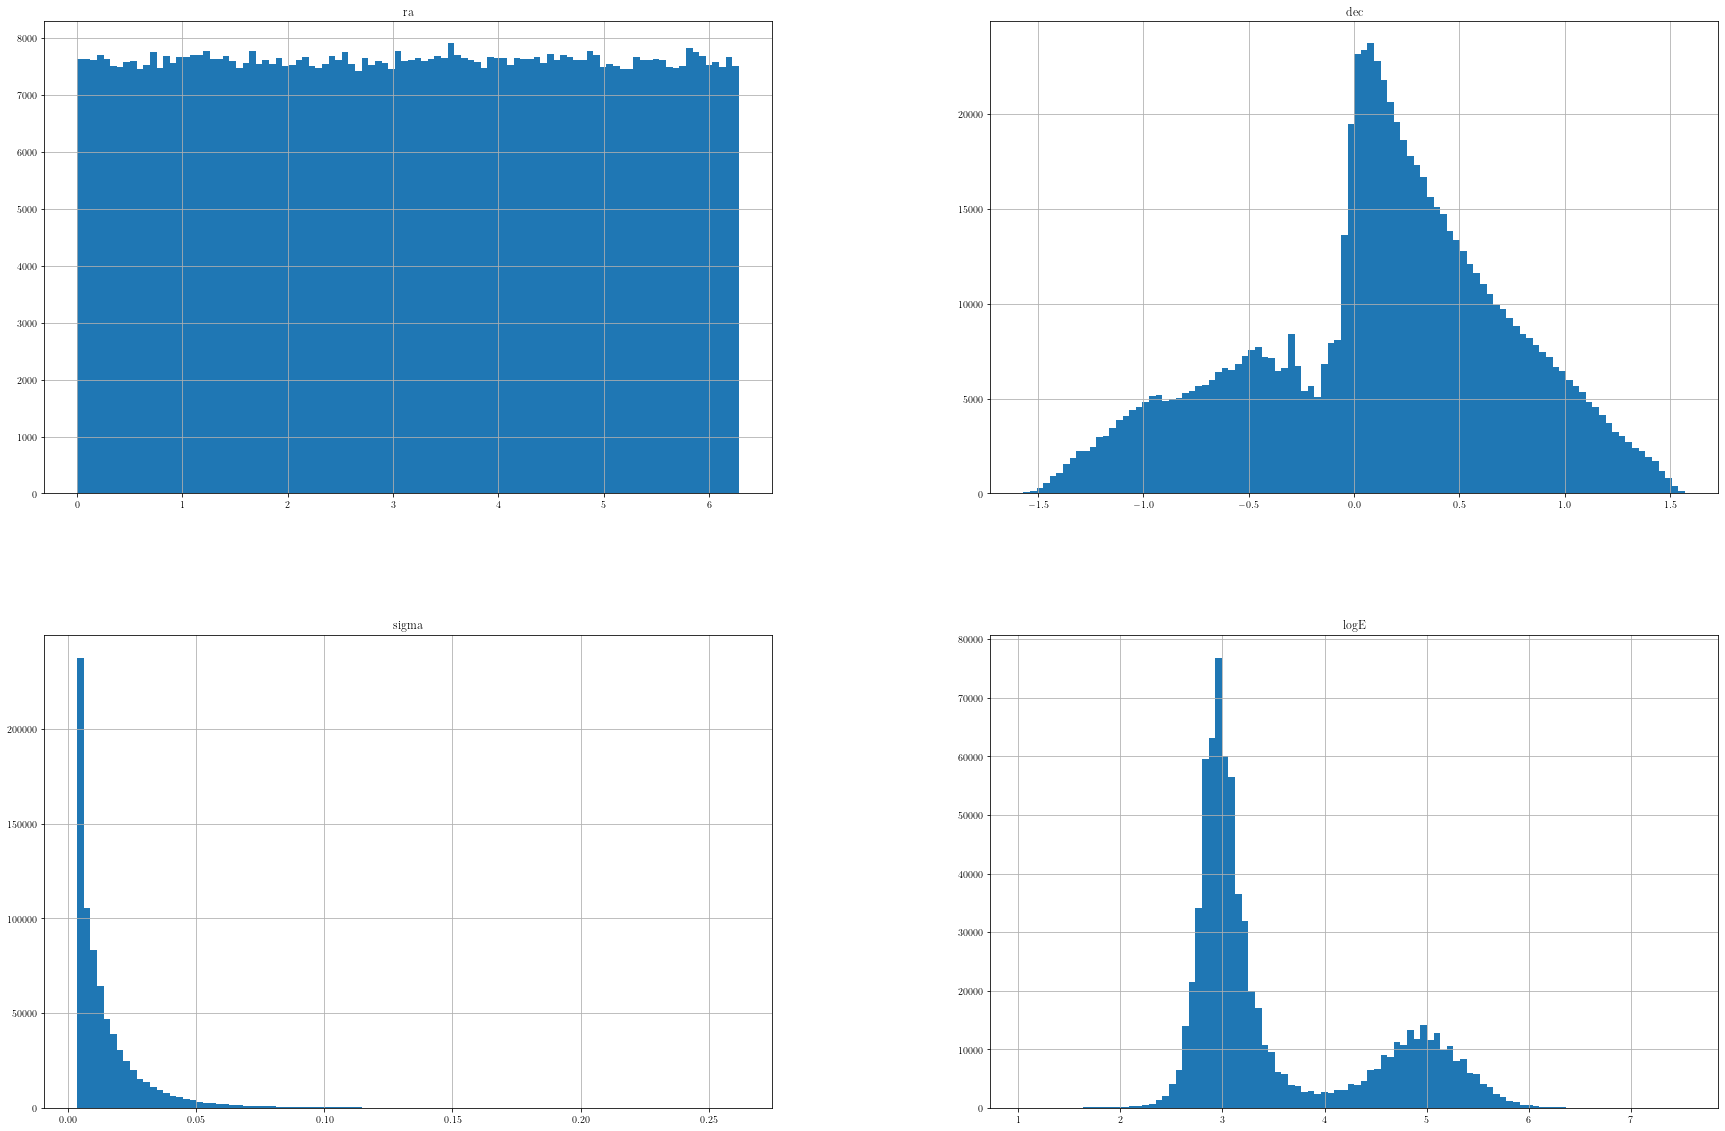

In [4]:
# generate background-only data
bg_events = bgGen.scramble()
print (bg_events); hist = bg_events.hist(bins=100, figsize=(30, 20))

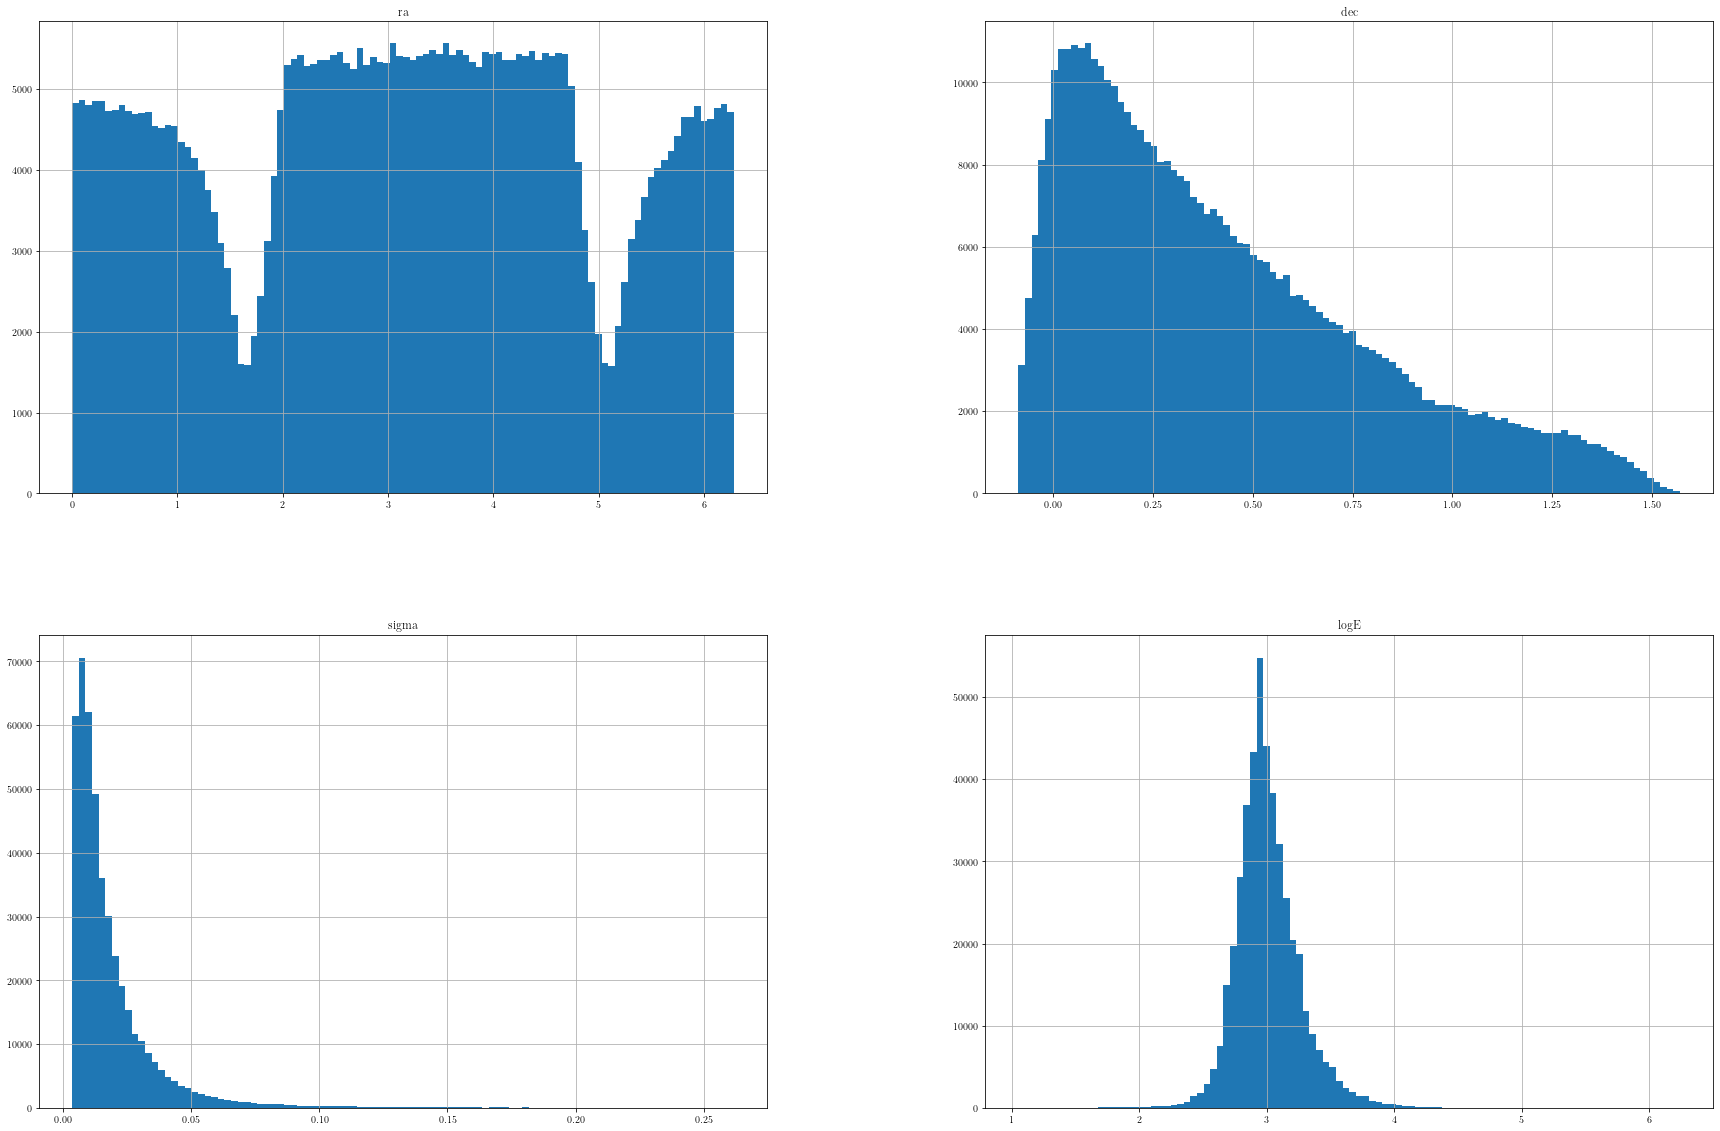

In [5]:
# mask backgound-only events
# mask galactic plane and events from southern hemisphere
dec = bg_events['dec']
ra = bg_events['ra']

c_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs', unit = (u.radian, u.radian))
index = (np.where(np.abs(c_icrs.galactic.b.degree) >= 10))
masked_bg_events = bg_events.iloc[index]

index = (np.where(np.degrees(masked_bg_events['dec'].values) >- 5))
masked_bg_events = masked_bg_events.iloc[index[0]]

hist = masked_bg_events.hist(bins=100, figsize=(30, 20))

In [6]:
# below are the codes for generating synthetic astro + atm events

# selecting sources for astrophysical events generation
# this result in a f_astro ~ 0.0374 with normalization of 5e-16
num_sources = 1750
selected_sources = np.array(random.sample(WISE_data_test, num_sources))
synthetic_astro = np.radians(generate_synthetic_nu(selected_sources, powerlaw_integral_flux))

# mask the synthetic astrophysical events
synthetic_astro = mask_galactic(np.array(mask_southern(synthetic_astro[:,0], synthetic_astro[:,1])))

# combine background-only events with synthetic astrophysical events
bg_holder = to_coordinates(masked_bg_events['dec'].to_numpy(), masked_bg_events['ra'].to_numpy())
bg_exclude_astro = np.array(random.sample(bg_holder, len(bg_holder)-len(synthetic_astro)))
synthetic_astro_atm = np.append(bg_exclude_astro, synthetic_astro, axis = 0)

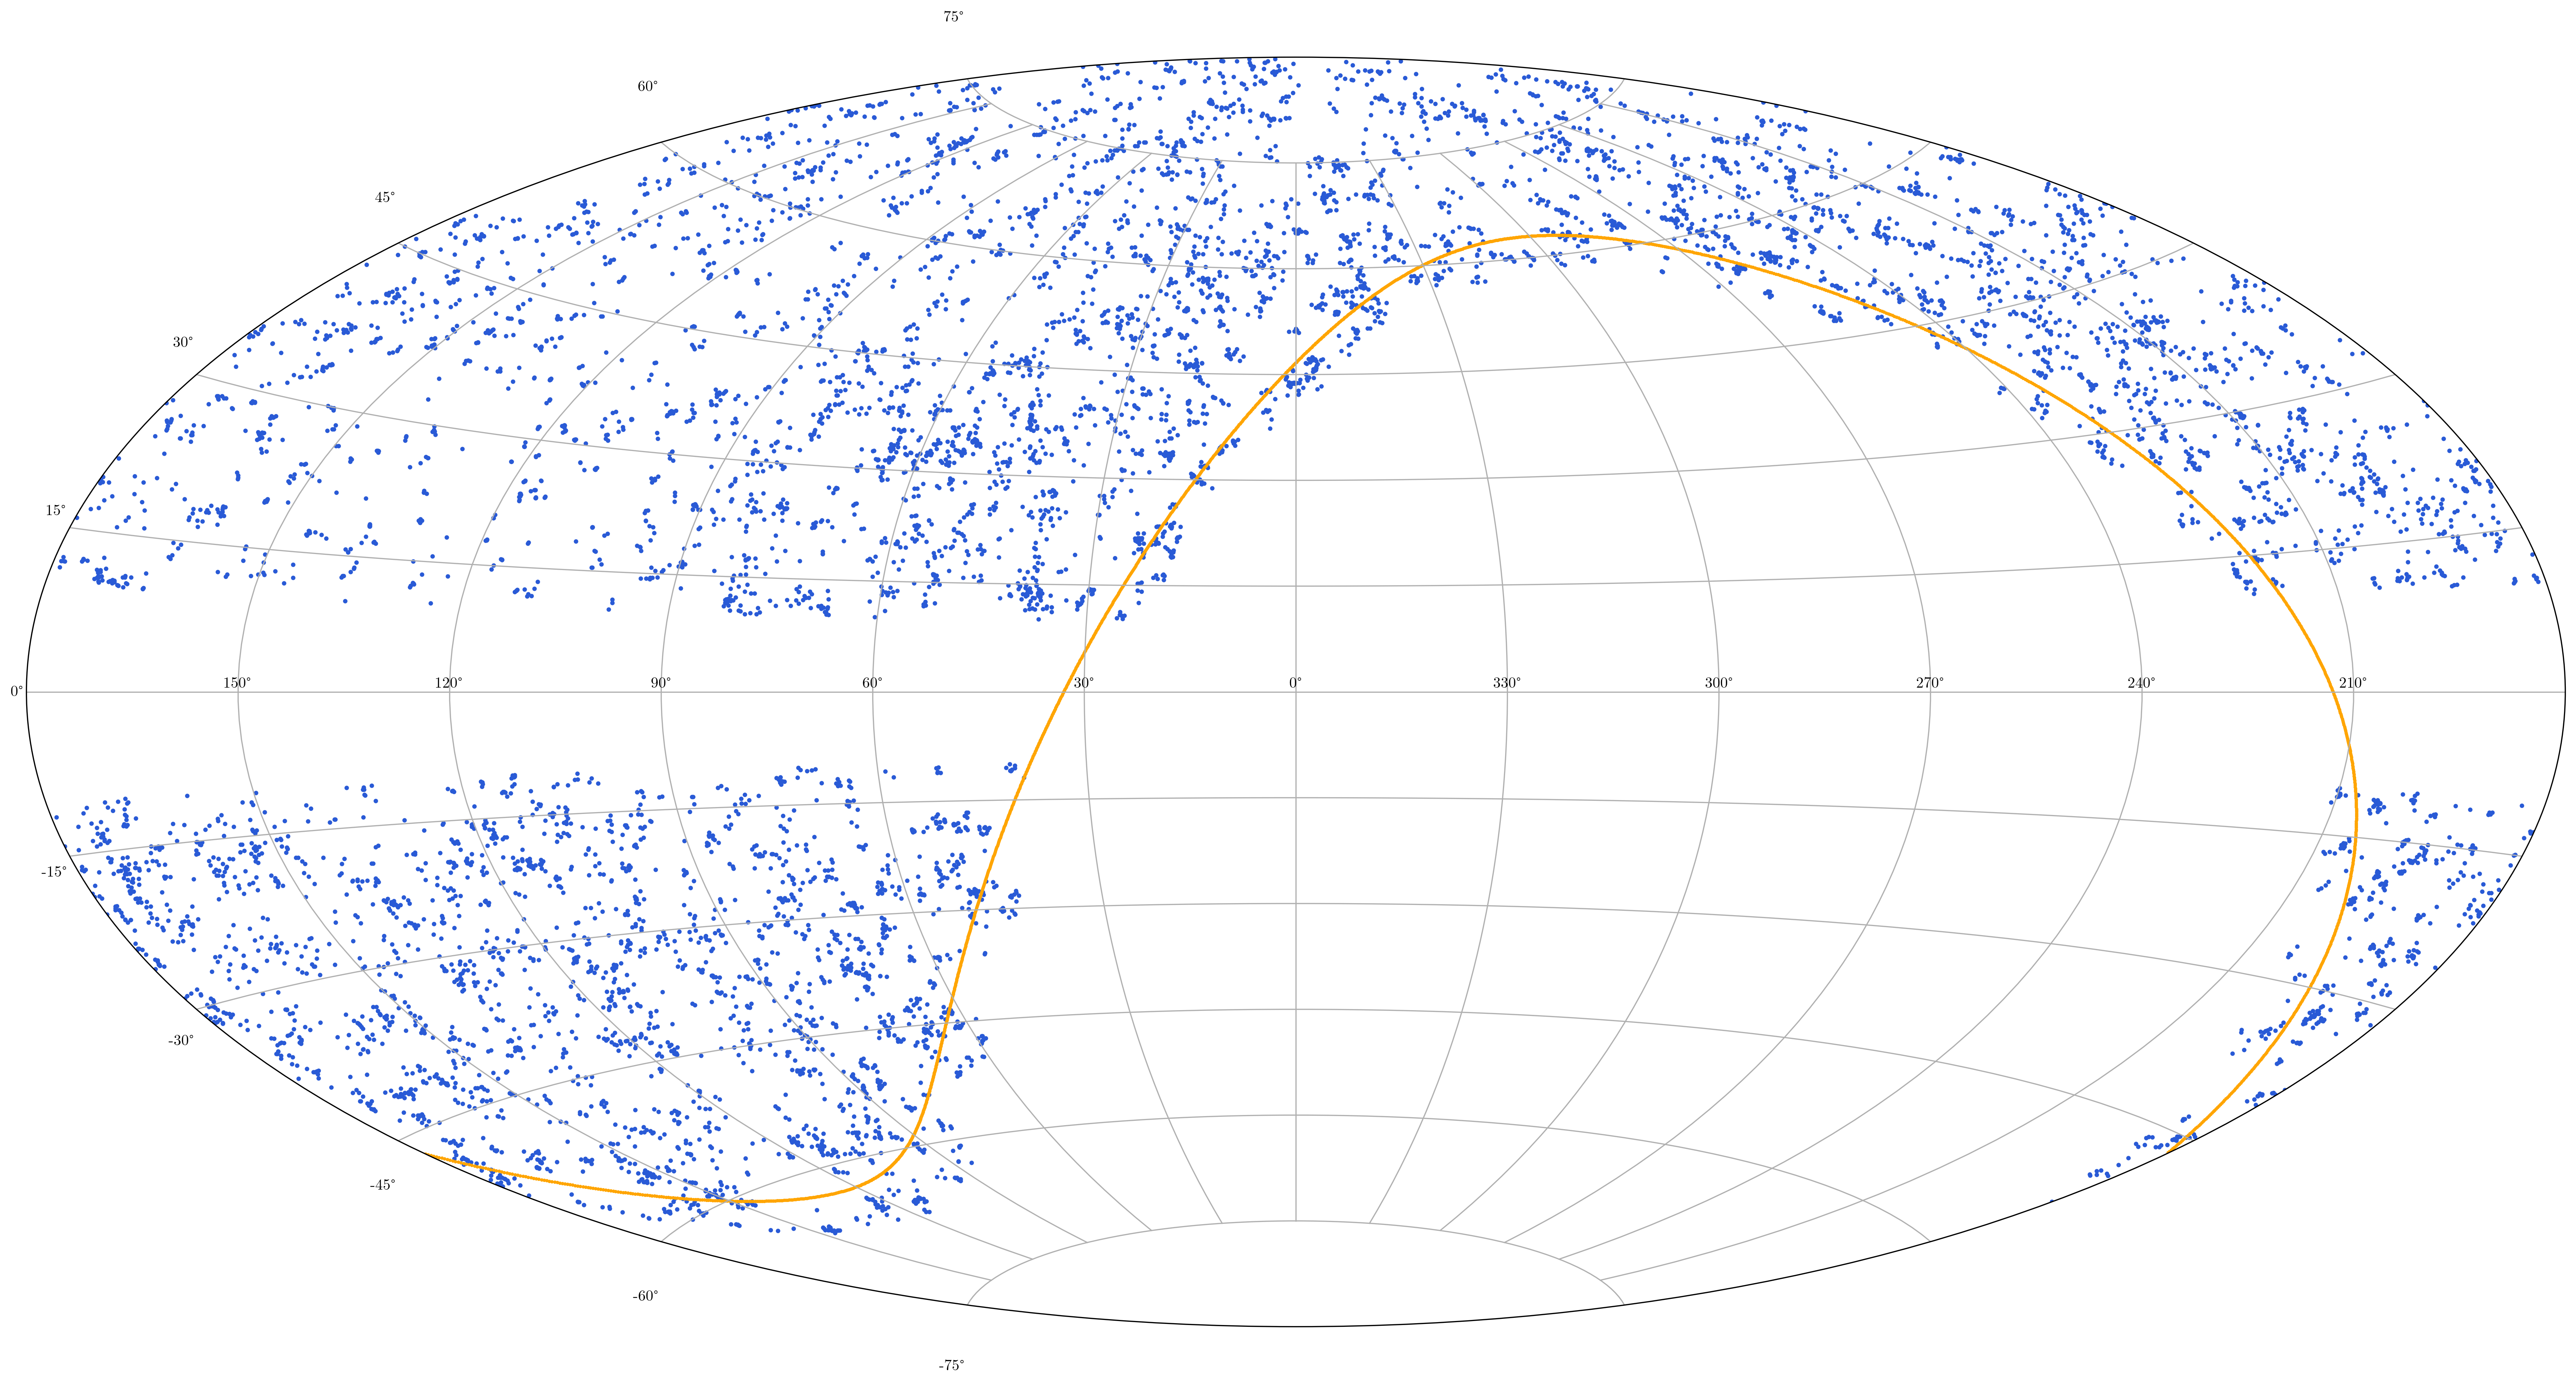

In [7]:
# plot of the synthetic astrophysical events from the selected sources
# the orange line is the celestial equator
plot_galactic(synthetic_astro)

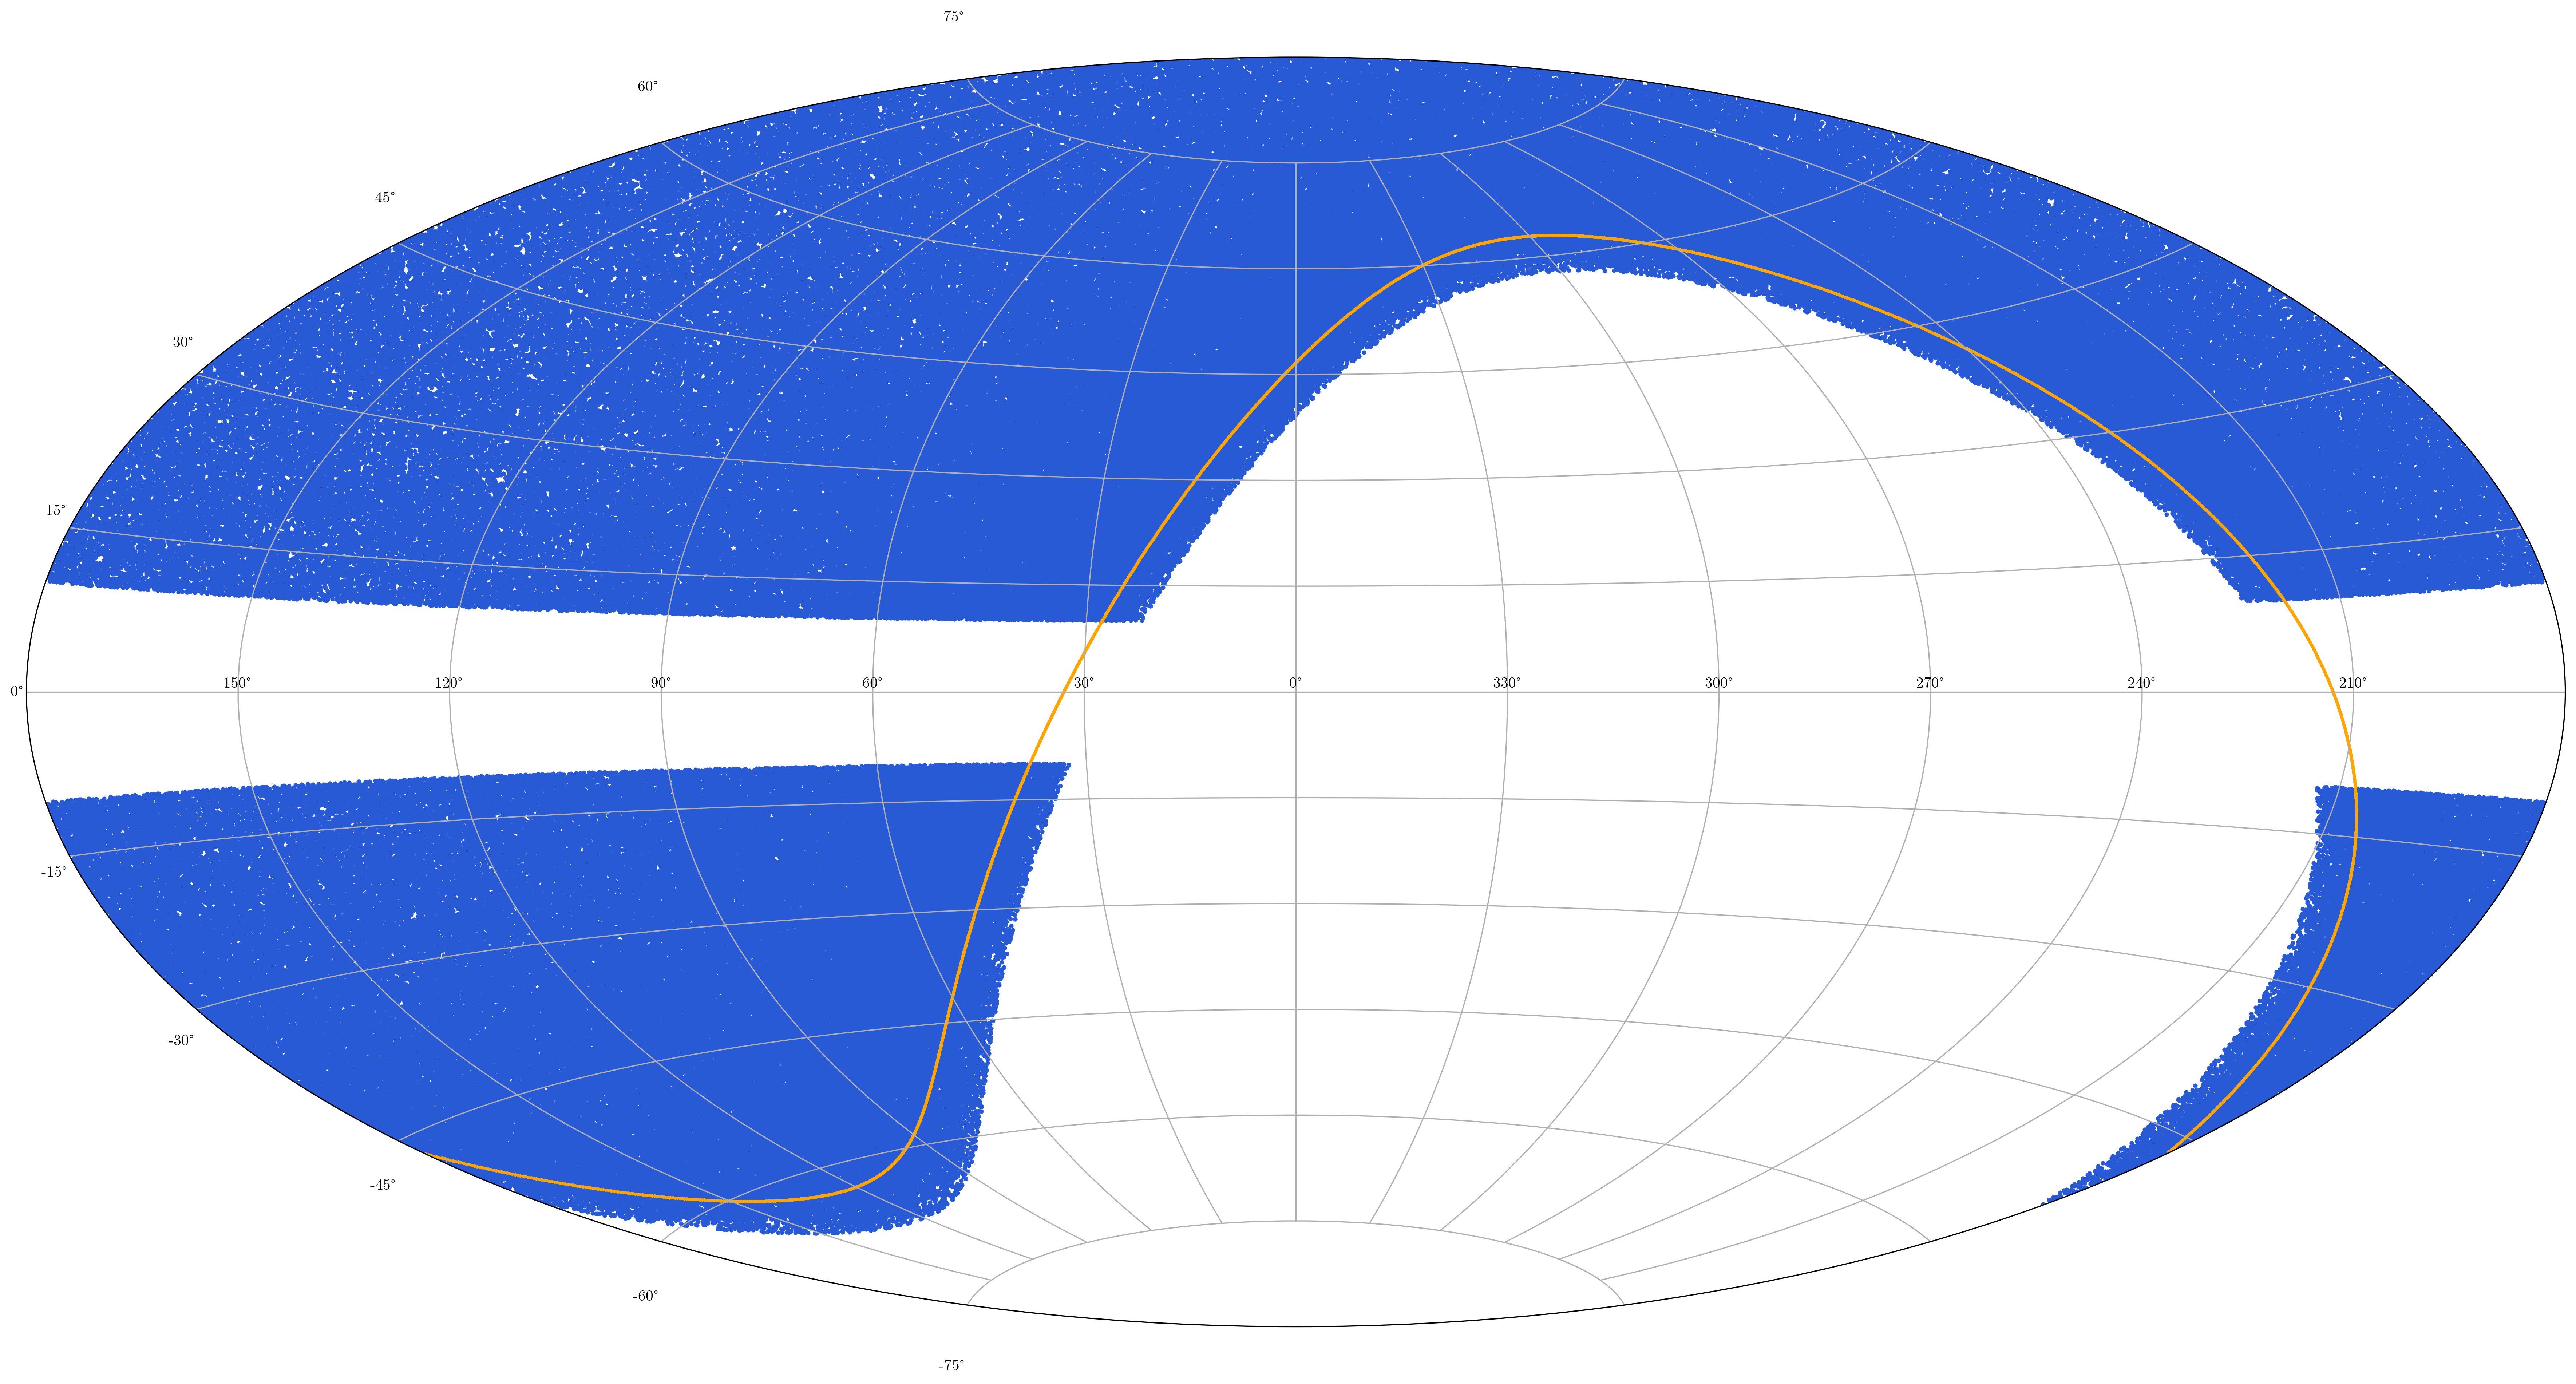

In [8]:
# plot of the background-only events
# the orange line is the celestial equator
plot_galactic(bg_exclude_astro)

             Dec        Ra
0       0.534839  4.206972
1       1.100221  5.000684
2       0.232879  2.786952
3       0.699633  2.050818
4       0.884219  2.121107
...          ...       ...
452122  0.434067  4.640227
452123  0.439537  4.669566
452124  0.436268  4.630613
452125  0.434902  4.651882
452126  0.427242  4.652982

[452127 rows x 2 columns]


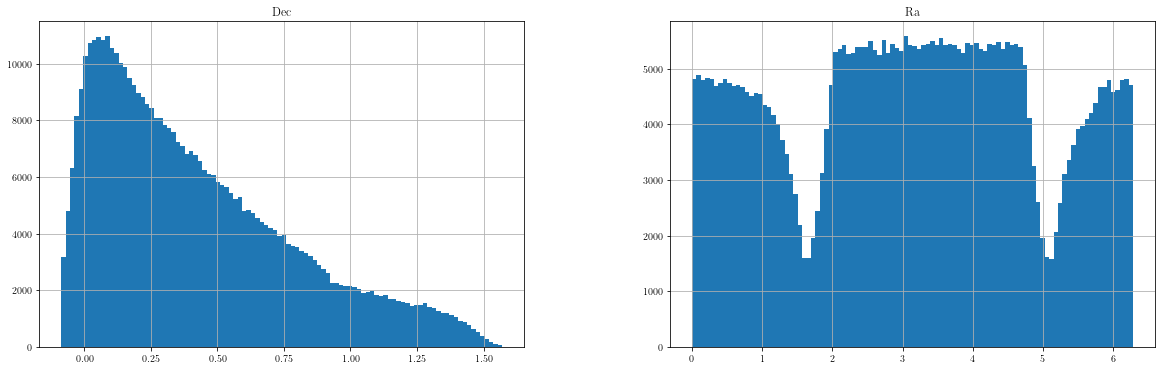

In [9]:
# the final synthetic atm + astro dataset is in the format of [Dec, RA], both in radians
synthetic_nu = pd.DataFrame({"Dec":synthetic_astro_atm[:,0], "Ra":synthetic_astro_atm[:,1]})
print (synthetic_nu); hist = synthetic_nu.hist(bins=100, figsize=(20, 6))